# HandsON ML with Scikit-Learn, Keras & TensorFlow  
[데이터 자료 가져오기](https://github.com/rickiepark/handson-ml2)

## 3장 . 분류


### 3.1 MNIST 
- 고등학생과 미국 인구조사국 직원들이 손으로 쓴 70,000개의 작은 숫자 이미지를 모은 MNIST 데이터셋 사용

In [75]:
#mnist 데이타셋 가져오기
from sklearn.datasets import fetch_openml

#matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

#SGDClassifier
from sklearn.linear_model import SGDClassifier

#cross_val_score 구현
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone


#cross_val_score 
from sklearn.model_selection import cross_val_score

#더미 분류기
from sklearn.base import BaseEstimator

#오차행렬 예측값 
from sklearn.model_selection import cross_val_predict

#오차행렬 생성
from sklearn.metrics import confusion_matrix

#정밀도와 재현율
from sklearn.metrics import precision_score , recall_score
#조화평균
from sklearn.metrics import f1_score

#presicion_recall_curve()
from sklearn.metrics import precision_recall_curve

#ROC곡선
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#RFC
from sklearn.ensemble import RandomForestClassifier

### 2021/03/07
### 3.1.2 MNIST 데이터 내려받기

In [3]:
mnist = fetch_openml('mnist_784', version = 1)

- 사이킷런에서 읽어들인 데이터셋은 일반적으로 비슷한 딕셔너리 구조를 가진다.

In [4]:
mnist.keys() #key_value 출력

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

-배열들을 살펴보자

In [5]:
X, y = mnist["data"], mnist["target"]
X.shape, y.shape

((70000, 784), (70000,))

- 이미지가 70,000개 있고 각 이미지에는 784개의 Feature가 존재한다.  
- 이미지는 28x28픽셀  
- 이미지를 추출해서 28x28 배열로 크기를 맞추고 matplotlib의 imshow 함수를 사용해서 출력해보자

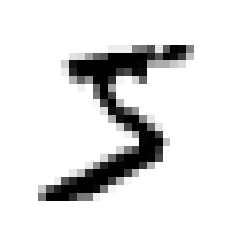

In [6]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

#전체 데이터셋 확인

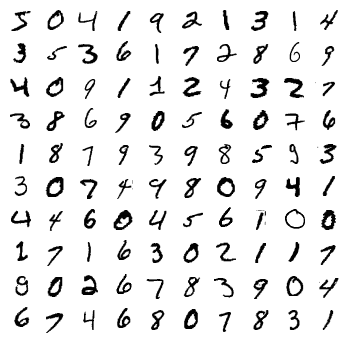

In [7]:
plt.figure(figsize=(6,6))
for i in range(100):
    some_digit2 = X[i]
    some_digit_image2 = some_digit2.reshape(28,28)
    
    plt.subplot(10,10,i+1)
    plt.imshow(some_digit_image2, cmap="binary")
    plt.axis("off")
plt.show()

In [8]:
y[0] #실제 레이블 확인

'5'

 - 레이블은 문자열이므로 머신러닝 알고리즘에 맞추기위해 y를 정수로 변환시켜줄 것이다. 

In [9]:
y = y.astype(np.uint8)

데이터를 조사하기 전에 항상 테스트 세트를 만들고 떼어놓아야한다.

In [10]:
X_train , X_test , y_train, y_test = X[:60000],X[60000:],y[:60000],y[60000:]

- 훈련 세트는 이미 섞여있어서 모든 교차 검증 폴드를 비슷하게 만든다.
- 많은 비슷한 샘플이 연이어 나타나게 되면 성능이 나빠지므로 데이터셋을 섞어 이런 문제를 사전에 방지해야한다.

### 3.2 이진 분류기 훈련
- 문제를 단순화해서 하나의 숫자 (ex = 5)만 식별해보는 작업을 해보자.
- 5와 5가 아닌 경우만을 구분하는 이진 분류기를 만든다.

In [11]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

- 이제 분류모델을 하나 선택하여 훈련시켜볼 것이다.
- sklearn의 SGDClassifier클래스를 사용하여 확률적 경사하강법 분류기를 만든다.
- 확률경사하강법 분류기는 매우 큰 데이터셋을 효율적으로 처리하는 장점을 가지고 있다.
- 훈련하는 데 무작위성을 사용하여 결과를 재현하기 위해서는 random_state 매개변수를 지정해야한다. 

In [12]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [13]:
#숫자 5 이미지 감지
sgd_clf.predict([some_digit])

array([ True])

- 분류기는 이 이미지가 5를 나타내고 있다고 추측
- 분류기 모델의 성능을 평가해보자!

### 3.3 성능 측정
### 3.3.1 교차검증을 사용한 정확도 측정
- 교차검증은 모델을 평가하는 좋은 방법
- 사이킷런의 cross_val_score() 함수와 거의 같은 작업을 수행하는 코드를 직접 구현해보자

In [14]:
skfolds = StratifiedKFold(n_splits = 3, random_state = 42, shuffle = True)
#StratifiedKFold 는 클래스별 비율이 유지되도록 폴드를 만들기 위해 계층적 샘플링 수행
# 매 반복에서 분류기 객체를 복제하여 훈련 폴드로 훈련시키고 테스트 폴드로 예측 생성
# 올바른 예측 수를 세어 정확한 예측의 비율을 출력한다.
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))
    

0.9669
0.91625
0.96785


In [15]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring = "accuracy")

array([0.95035, 0.96035, 0.9604 ])

모든 교차 검증 폴등에 대해 정확도가 95% 이상이 나온 것을 확인 가능하다.  
모든 이미지를 5 아님 클래스로 분류하는 더미 분류기를 만들어보자

In [16]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)

In [17]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5 , cv = 3, scoring = "accuracy")

array([0.91125, 0.90855, 0.90915])

정확도가 90% 이상으로 나온 것을 확인  
10%정도만 숫자가 5라는 의미이기 때문에 무조건 5 아님으로 예측하게 되면 정확히 맞출 확률이 90%가 된다는 의미  
- 그러나 정확도 분류기는 불균형한 데이터셋을 다룰때 좋지않으며 성능 측정 지표로 적절하지 않다.

### 3.3.2 오차 행렬
- 분류기의 성능을 평가하는 더 좋은 방법
- 오차 행렬을 조사하여 잘못 분류한 횟수를 센다
- ex) 클래스 A의 샘플이 클래스 B로 잘못 분류된 횟수 5 -> 3 이라면 오차행렬의 5행 3열을 본다  
  
  
- 실제 타깃과 비교할 수 있도록 먼저 예측값을 만들어야 한다. 

In [18]:
#cross_val_predict() 를 사용하여 예측값 생성
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred

array([ True, False, False, ...,  True, False, False])

K-겹 교차검증을 수행하지만 score와는 다르게 평가 점수가 아닌 테스트 폴드에서 얻은 예측 결과를 반환하는 것을 알 수 있다.

In [19]:
#confusion_matrix()를 이용해 오차 행렬 생성 
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

오차 행렬의 행은 실제 클래스를 나타내고 열은 예측한 클래스  
[0,0] = 5가 아닌 것을 정확하게 분류한 것(53,892)   
[0,1] = 5가 아닌 것을 5라고 분류한 것(687)   
[1,0] = 5인 것을 5가 아닌 것으로 분류한 것(1,891)  
[1,1] = 5인 것을 5라고 정확하게 분류한 것(3,530)  

In [22]:
#완벽한 분류기 - 진짜 양성인 경우 or 진짜 음성인 경우만 표현
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

### 3.3.3 정밀도와 재현율
- 사이킷 런은 정밀도와 재현율을 포함하여 분류기의 지표를 계산하는 여러 함수를 제공한다.
- 정밀도란?  
양성예측의 정확도 - 양성을 예측한 것 중 정확하게 양성인 경우   
$TP/(TP+FP)$
- 재현율이란?  
분류기가 정확하게 감지한 양성 샘플의 비율, 민감도라고도 함  
$TP/(TP+FN)$

In [26]:
precision_score(y_train_5, y_train_pred) 

0.8370879772350012

In [34]:
#정밀도
cm = confusion_matrix(y_train_5, y_train_pred)
cm[1, 1] / (cm[0, 1] + cm[1, 1])

0.8370879772350012

In [27]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [31]:
#재현율
cm[1, 1] / (cm[1, 0] + cm[1, 1])

0.6511713705958311

5로 판별된 이미지 중 83%만 정확하고 전체 숫자 5에서도 65%만 감지했다.
- 두 점수를 F1이라는 하나의 숫자로 만들어 비교한다
- F1은 조화평균

In [36]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

정밀도를 올리면 재현율이 줄어들고 정밀도를 줄이면 재현율이 늘어나는 현상을 정밀도/재현율 트레이드오프 라고 한다 

### 3.3.4 정밀도/재현율 트레이드오프
- SGDClassifier가 분류를 어떻게 결정하는지 살펴보자
- 이 분류기는 결정함수를 사용하여 각 샘플의 점수를 계산하여 임곗값보다 큰 경우  
샘플을 양성클래스에 할당하고 그렇지 않은 경우 음성 클래스에 할당한다.
- 결정 임곗값을 정하고 높이거나 낮추면서 정밀도와 재현율을 구한다.
- 임곗값이 높아질수록 정밀도가 높아지고 낮아질수록 재현율이 높아진다.

사이킷 런을 통해 예측에 사용한 점수를 확인하여 그 점수를 기반으로 원하는 임곗값을 정해 예측을 만들 수 있다.

In [39]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [42]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

SGDClassifier 임곗값이 0이므로 predic()메서드와 같은 결과 True를 반환  
임곗값을 8000으로 올려보자

In [43]:
threshold = 8000
y_some_digit_pred =  (y_scores > threshold)
y_some_digit_pred

array([False])

임곗값을 올린 결과 재현율이 줄어든다는 것을 보여주었다.   
적절한 임곗값을 정하기 위해 cross_val_predict()함수를 사용해 결정 점수를 반환하도록 지정해야한다. 

In [44]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

가능한 모든 임곗값에 대한 정밀도와 재현율을 그래프로 나타내어보자

In [47]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

C:\Users\sanga\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\sanga\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 48128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\sanga\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\sanga\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51116 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\sanga\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 54788 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\sanga\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 50984 missing from current

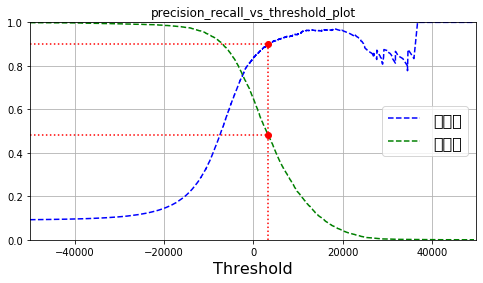

In [54]:
#Matplotlib을 통해 임곗값의 함수로 정밀도와 재현율을 그리자 
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1],"b--",label="정밀도")
    plt.plot(thresholds, recalls[:-1],"g--",label="재현율")
    #임곗값을 표시하고 범례, 축 이름. 그리드를 추가한다.
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)       
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1])    
    
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             
plt.title("precision_recall_vs_threshold_plot")                                           
plt.show()


In [55]:
(y_train_pred == (y_scores > 0)).all()

True

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
plt.title("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

In [56]:
(y_train_pred == (y_scores > 0)).all()

True

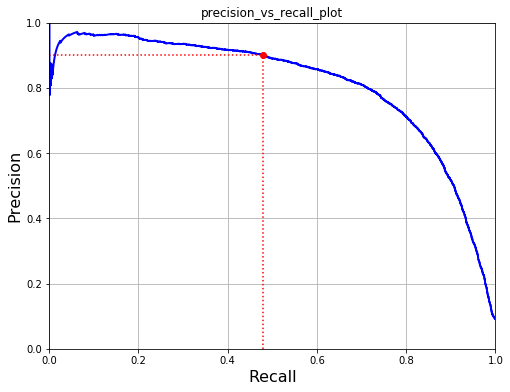

In [58]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.title("precision_vs_recall_plot")
plt.show()

좋은 정밀도/재현율 트레이드오프를 선택하는 다른 방법은 재현율에 대한 정밀도 곡선을 그리는 것  
재현율 80%근처에서 정밀도가 급격히 줄어들어 이 하강점 직전을 정밀도/재현율 트레이드오프로 선택한다.
  


In [59]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [63]:
#훈련셋에대한 예측
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [65]:
precision_score(y_train_5, y_train_pred_90),recall_score(y_train_5, y_train_pred_90)

(0.9000345901072293, 0.4799852425751706)

정밀도 90%인 분류기를 만들었다.  
충분히 큰 임곗값을 정하면 끝이지만 재현율이 지나치게 낮다면 높아봤자 아무 소용이 없다.

### 3.3.5 ROC곡선
- 이진분류에서 널리 사용하는 도구  
- 정밀도/재현율 곡선과 비슷하지만 거짓양성비율에 대한 진짜양성비율의 곡선임
- 민감도에 대한 특이도의 그래프 
- roc_curve()함수 사용

In [68]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores) #거짓양성비율, 진짜양성비율, 임계치

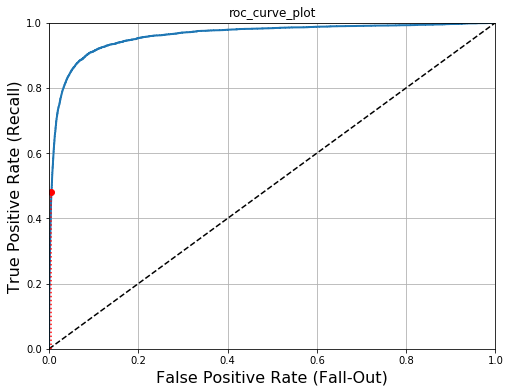

In [70]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # 대각 점선
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                           

plt.figure(figsize=(8, 6))                                  
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]        
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:") 
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:") 
plt.plot([fpr_90], [recall_90_precision], "ro")              
plt.title("roc_curve_plot")                                   
plt.show()

In [71]:
recall_90_precision

0.4799852425751706

47.99%의 재현율  
재현율이 높을수록 분류기가 만드는 거짓양성비율이 늘어난다.  
대각선 점선에서 멀리 떨어져있을 수록 좋은 분류기라고 할 수 있다.

In [74]:
#ROC곡선의 면적(AUC)을 계산
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

RandomForestClassifier를 훈련시켜 SGDClassifier의 ROC곡선과 AUC점수를 비교해보자.

In [77]:
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

Roc_curve()는 레이블과 점수를 기대한다.  
점수 대신에 클래스 확률을 전달할 수 있으므로 양성 클래스 확률을 점수로 사용해보자

In [79]:
y_scores_forest = y_probas_forest[:, 1] # 점수 = 양성 클래스의 확률
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

첫 번째 ROCcurve와 두 번째 ROCcurve를 그려보자

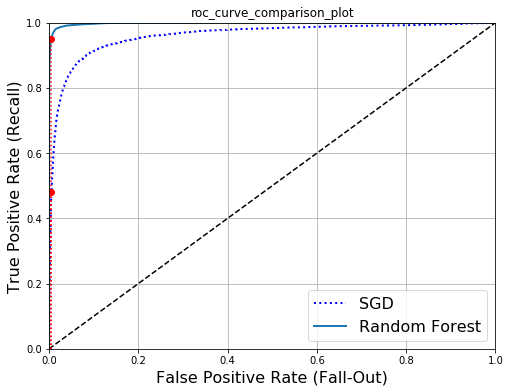

In [81]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")

plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.title("roc_curve_comparison_plot")
plt.show()

RFC Roc곡선이 왼쪽 위 모서리에 더 가까워서 SGD보다 좋아보인다.  
AUC 점수도 훨씬 높게 나온다.

In [86]:
roc_auc_score(y_train_5, y_scores_forest) #SGD_AUC = 0.9604938554008616

0.9983436731328145

정밀도와 재현율 점수를 계산하면 99% 정밀도와 86% 재현율이 산출된다.

In [84]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [85]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591